# Model Fitting I

We want to find the causal effect of studying on grades, so we will be using some econometric techniques, focusing on causal inference. We will first run a naive OLS fit, and then demonstrate why it is inappropriate in this context.

### Naive OLS Fit

The naive approach would be to use these data to fit a "kitchen sink" OLS regression to the data. So lets see what this regression would yield, and then address the plausibility of these results. We run a model for each of our `studytime` mapping schemes.

*Note: We are using MacKinnon and White's (1985) HC3 heteroskedasticity robust covariance estimator*

In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.iv import IV2SLS 

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [2]:
# Loading the data
student_perf = pd.read_pickle('data/student_por_v2.pkl')

Before we fit our the OLS model let's clean up our dataset by converting strings to indicators and converting the final `G3` score into a percentage. We'll be using our make_indicator function located in p3functions.py. 

In [3]:
# Data formatting - converting categorical variables to indicators
indicator_names = {
    'school_GP': ('school', 'GP'),
    'male': ('sex', 'M'),
    'urban': ('address', 'U'),
    'fam_small': ('famsize', 'LE3'),
    'fam_split': ('Pstatus', 'A'),
    
    'no_parent': ('guardian', 'other'),
    'father': ('guardian', 'father'),
    'mother': ('guardian', 'mother'),
    
    'school_sup': ('schoolsup', 'yes'),
    'famsup': ('famsup', 'yes'),
    'paid': ('paid', 'yes'),
    'activities': ('activities', 'yes'),
    'nursery': ('nursery', 'yes'),
    'higher': ('higher', 'yes'),
    'internet': ('internet', 'yes'),
    'romantic': ('romantic', 'yes'),
    
    'Mjob_teach': ('Mjob', 'teacher'),
    'Mjob_health': ('Mjob', 'health'),
    'Mjob_civil': ('Mjob', 'services'),
    'Mjob_other': ('Mjob', 'other'),
    'Fjob_teach': ('Fjob', 'teacher'),
    'Fjob_health': ('Fjob', 'health'),
    'Fjob_civil': ('Fjob', 'services'),
    'Fjob_other': ('Fjob', 'other'),
    
    'Medu_primary': ('Medu', 1),
    'Medu_5_9': ('Medu', 2),
    'Medu_secondary': ('Medu', 3),
    'Medu_higher': ('Medu', 4),
    'Fedu_primary': ('Fedu', 1),
    'Fedu_5_9': ('Fedu', 2),
    'Fedu_secondary': ('Fedu', 3),
    'Fedu_higher': ('Fedu', 4),
    
    'reason_home' : ('reason', 'home'),
    'reason_course' : ('reason', 'course'),
    'reason_reputation' : ('reason', 'reputation'),
    
    'traveltime_0_15m' : ('traveltime', 1),
    'traveltime_15_30m' : ('traveltime', 2),
    'traveltime_30m_1h' : ('traveltime', 3),
    'traveltime_1h_plus' : ('traveltime', 4),
    
    'famrel_1' : ('famrel', 1),
    'famrel_2' : ('famrel', 2),
    'famrel_3' : ('famrel', 3),
    'famrel_4' : ('famrel', 4),
    'famrel_5' : ('famrel', 5),
    
    'freetime_1' : ('freetime', 1),
    'freetime_2' : ('freetime', 2),
    'freetime_3' : ('freetime', 3),
    'freetime_4' : ('freetime', 4),
    'freetime_5' : ('freetime', 5),
    
    'goout_1' : ('goout', 1),
    'goout_2' : ('goout', 2),
    'goout_3' : ('goout', 3),
    'goout_4' : ('goout', 4),
    'goout_5' : ('goout', 5),

    'Dalc_1' : ('Dalc', 1),
    'Dalc_2' : ('Dalc', 2),
    'Dalc_3' : ('Dalc', 3),
    'Dalc_4' : ('Dalc', 4),
    'Dalc_5' : ('Dalc', 5),

    'Walc_1' : ('Walc', 1),
    'Walc_2' : ('Walc', 2),
    'Walc_3' : ('Walc', 3),
    'Walc_4' : ('Walc', 4),
    'Walc_5' : ('Walc', 5),

    'health_1' : ('health', 1),
    'health_2' : ('health', 2),
    'health_3' : ('health', 3),
    'health_4' : ('health', 4),
    'health_5' : ('health', 5),
}
make_indicators(student_perf, indicator_names)

# Converting G3 to percent
student_perf['G3_perc'] = student_perf.G3 / 12

In [4]:
# Running the OLS model with discrete mapping
## Note: we leave out the first group from `studytime` for collinearity purposes
Y = student_perf.G3_perc
X = student_perf[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                  'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results_discrete = model.fit(cov_type='HC3')
print(results_discrete.summary(title = 'OLS Regression Results: Discrete Map'))

                     OLS Regression Results: Discrete Map                     
Dep. Variable:                G3_perc   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     5.720
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           6.39e-33
Time:                        15:41:10   Log-Likelihood:                 102.33
No. Observations:                 649   AIC:                            -68.66
Df Residuals:                     581   BIC:                             235.7
Df Model:                          67                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5661      0

In [5]:
# Running the OLS model with continuous mapping
Y = student_perf.G3_perc
X = student_perf[['studytime_continuous',
                  'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results_continuous = model.fit(cov_type='HC3')
print(results_continuous.summary(title = 'OLS Regression Results: Continuous Map'))

######
#print(results_continuous.summary(title = 'OLS Regression Results: Continuous Map').as_latex())
######

                    OLS Regression Results: Continuous Map                    
Dep. Variable:                G3_perc   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     5.905
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           1.29e-33
Time:                        15:41:17   Log-Likelihood:                 101.26
No. Observations:                 649   AIC:                            -70.53
Df Residuals:                     583   BIC:                             224.9
Df Model:                          65                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5286 

In both models our $R^2$ and adjusted $R^2$ are low (around 0.35 - 0.4).

In [6]:
#Saving our cleaned dataset and results of our Naive OLS fit
student_perf.to_pickle('data/student_por_v3.pkl')
results_discrete.save('results/Naive_OLS_discrete.pickle')
results_continuous.save('results/Naive_OLS_continuous.pickle')

In [7]:
# Computing the Variance Inflation Factor
vif = pd.DataFrame({
    'Features' : X.columns,
    'VIF Factor' : [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Displaying the sorted VIF's after dropping the VIF for the intercept
vif.iloc[1:].sort_values(by = 'VIF Factor', ascending = False)

,Features,VIF Factor
31,Medu_higher,27.490742
29,Medu_5_9,26.160910
33,Fedu_5_9,24.140741
30,Medu_secondary,22.142360
28,Medu_primary,21.756254
32,Fedu_primary,21.361527
35,Fedu_higher,19.169556
34,Fedu_secondary,18.518848
54,Dalc_1,5.376143
27,Fjob_other,4.966461


In [8]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.01)
test = clf.fit(X, Y)
test.coef_

array([ 0.        ,  0.010227  ,  0.08481787, -0.00714837,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.11505364, -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.06352612,  0.        , -0.        , -0.00243671,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.0283987 , -0.0017112 , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.01321436,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.02676619,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.00780189])

In [9]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha = 0.1)
test = clf.fit(X, Y)
test.coef_

array([ 0.        ,  0.00855286,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.00000549,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ])

In [6]:
from quadratic2SLS import *

Y = student_perf.G3_perc
X = student_perf[['school_GP', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_perf['studytime_continuous']
Z = student_perf[['male',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model = Quadratic2SLS(Y, X, X_endog, Z)

In [17]:
result = model.fit(cov_type='Bootstrap', n_iter=10)
#result.summary()
#np.mean(result.beta_hat_boots[[1]])


100%|██████████| 10/10 [00:00<00:00, 42.41it/s]


In [18]:
result_20000 = model.fit(cov_type='Bootstrap', n_iter=20000)
result_20000.beta_hat_boots.mean(axis=0)

100%|██████████| 20000/20000 [07:10<00:00, 46.48it/s]


const                 0.549811
endog_hat            -0.000111
endog_sq_hat          0.000006
school_GP             0.105892
age                   0.016230
urban                 0.029722
fam_small             0.020795
fam_split            -0.008798
mother               -0.053881
father               -0.020032
failures             -0.129638
school_sup           -0.087936
famsup                0.005838
paid                 -0.031244
activities            0.015392
nursery              -0.011452
higher                0.162886
internet              0.013040
romantic             -0.021697
absences             -0.003400
Mjob_teach            0.010415
Mjob_health           0.039452
Mjob_civil            0.031756
Mjob_other           -0.003907
Fjob_teach            0.033752
Fjob_health          -0.033104
Fjob_civil           -0.032795
Fjob_other           -0.000999
Medu_primary         -0.032316
Medu_5_9             -0.048513
                        ...   
Fedu_primary         -0.028261
Fedu_5_9

In [35]:
result_20000.result2.params

const                 0.576214
endog_hat             0.071098
endog_sq_hat         -0.000071
school_GP             0.065094
age                   0.005051
urban                 0.028109
fam_small             0.025335
fam_split            -0.007573
mother               -0.008711
father                0.000565
failures             -0.099660
school_sup           -0.112664
famsup               -0.036889
paid                 -0.044287
activities           -0.008879
nursery              -0.020488
higher                0.087712
internet              0.008442
romantic             -0.033106
absences              0.001880
Mjob_teach            0.031102
Mjob_health           0.136044
Mjob_civil            0.042211
Mjob_other            0.002797
Fjob_teach            0.088675
Fjob_health          -0.174645
Fjob_civil           -0.036477
Fjob_other            0.020915
Medu_primary         -0.073185
Medu_5_9             -0.104877
                        ...   
Fedu_primary         -0.065140
Fedu_5_9

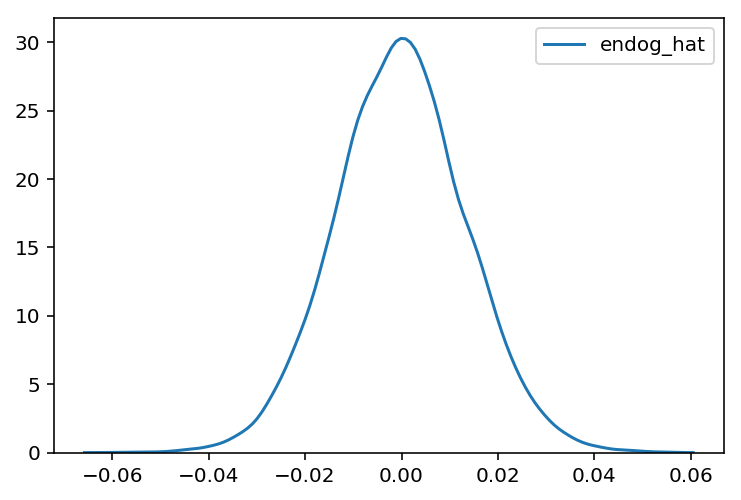

In [22]:
import seaborn as sns
sns.kdeplot(result_20000.beta_hat_boots['endog_hat'])

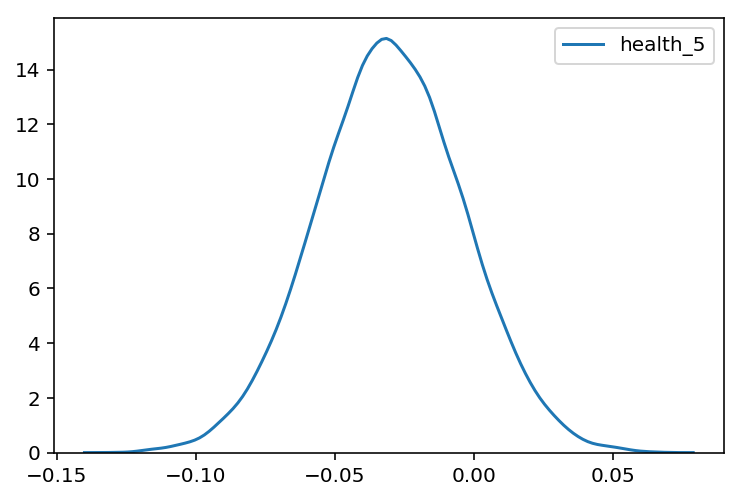

In [29]:
sns.kdeplot(result_20000.beta_hat_boots['health_5'])

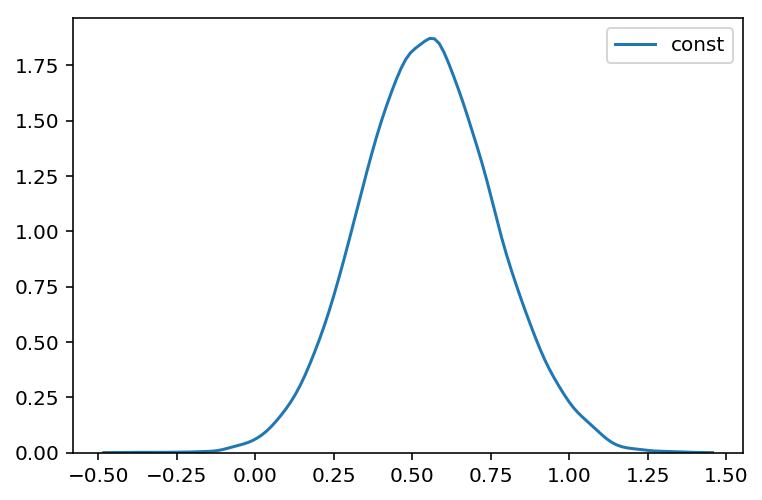

In [26]:
sns.kdeplot(result_20000.beta_hat_boots['const'])

In [32]:
result_20000.X_hat.columns

Index(['const', 'endog_hat', 'endog_sq_hat', 'school_GP', 'age', 'urban',
       'fam_small', 'fam_split', 'mother', 'father', 'failures', 'school_sup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'absences', 'Mjob_teach', 'Mjob_health', 'Mjob_civil',
       'Mjob_other', 'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
       'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher',
       'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher',
       'reason_home', 'reason_course', 'reason_reputation',
       'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
       'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5', 'freetime_1',
       'freetime_2', 'freetime_4', 'freetime_5', 'Dalc_1', 'Dalc_2', 'Dalc_4',
       'Dalc_5', 'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5', 'health_1',
       'health_2', 'health_4', 'health_5'],
      dtype='object')

In [70]:
import quadratic2SLS as q2sls
import importlib
importlib.reload(q2sls)

Y = student_perf.G3_perc
X = student_perf[['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_perf['studytime_continuous']
student_perf['artificial_instrument'] = 1*(student_perf.reason == 'home')*1*(student_perf.traveltime > 1)
Z = student_perf[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model = q2sls. Quadratic2SLS(Y, X, X_endog, Z, X, Z)
result = model.fit(cov_type='Bootstrap', n_iter = 50000)
result.beta_hat_boots.mean(axis=0)

100%|██████████| 50000/50000 [21:12<00:00, 39.28it/s]


const                 0.631638
endog_hat            -0.000024
endog_sq_hat          0.000001
school_GP             0.111870
male                 -0.062334
age                   0.013970
urban                 0.030176
fam_small             0.027143
fam_split            -0.014193
mother               -0.057019
father               -0.020679
failures             -0.124962
school_sup           -0.100040
famsup               -0.001871
paid                 -0.024277
activities            0.020281
nursery              -0.014922
higher                0.156103
internet              0.012806
romantic             -0.029016
absences             -0.003604
Mjob_teach            0.018813
Mjob_health           0.048248
Mjob_civil            0.038449
Mjob_other            0.002476
Fjob_teach            0.040306
Fjob_health          -0.038080
Fjob_civil           -0.033884
Fjob_other           -0.003435
Medu_primary         -0.009514
                        ...   
Fedu_primary         -0.061602
Fedu_5_9

In [71]:
result.result2.params

const                 0.598030
endog_hat             0.054964
endog_sq_hat          0.000045
school_GP             0.076259
male                 -0.023395
age                   0.006679
urban                 0.028395
fam_small             0.026813
fam_split            -0.010078
mother               -0.019258
father               -0.004280
failures             -0.103960
school_sup           -0.111571
famsup               -0.030877
paid                 -0.039287
activities           -0.001779
nursery              -0.019895
higher                0.101456
internet              0.009379
romantic             -0.032929
absences              0.000699
Mjob_teach            0.030767
Mjob_health           0.119591
Mjob_civil            0.042555
Mjob_other            0.003629
Fjob_teach            0.079143
Fjob_health          -0.148210
Fjob_civil           -0.036439
Fjob_other            0.015313
Medu_primary         -0.055770
                        ...   
Fedu_primary         -0.067723
Fedu_5_9

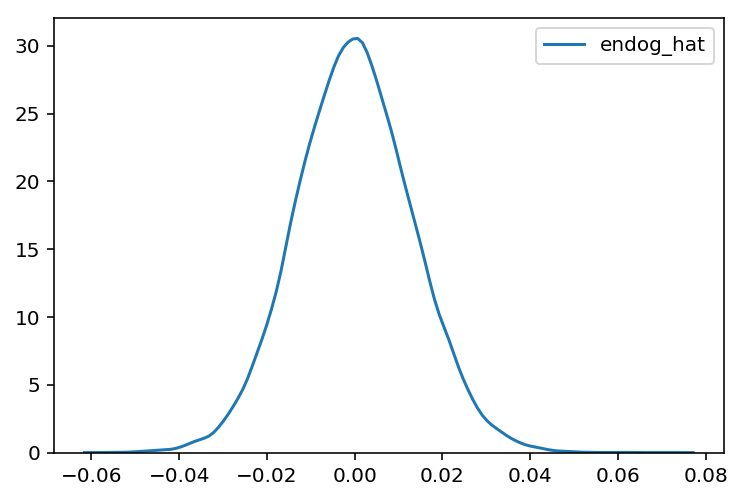

In [78]:
# density of coeff on endog_hat in bootstrapping
sns.kdeplot(result.beta_hat_boots['endog_hat'])

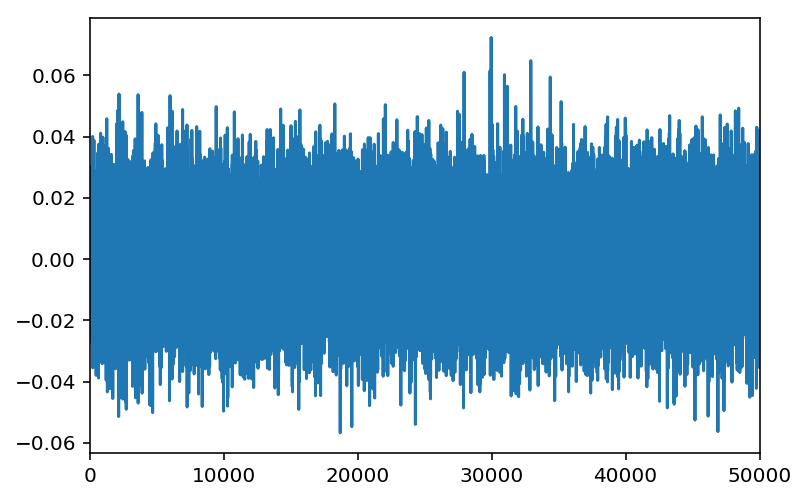

In [79]:
# stability of coeff on endog_hat in bootstrapping
sns.tsplot(result.beta_hat_boots['endog_hat'])

In [56]:
from linearmodels.iv import IV2SLS 
model = IV2SLS(Y, X, X_endog, Z)
results = model.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                G3_perc   R-squared:                      0.0999
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0064
No. Observations:                 649   F-statistic:                    334.49
Date:                Tue, Apr 17 2018   P-value (F-stat)                0.0000
Time:                        18:33:48   Distribution:                 chi2(61)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
const                    0.5993     0.2755     2.1756     0.0296      0.0594      1.1393
school_GP   

In [89]:
import quadratic2SLS as q2sls
import importlib
importlib.reload(q2sls)

Y = student_perf.G3_perc
X = student_perf[['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_perf['studytime_continuous']
student_perf['artificial_instrument'] = 1*(student_perf.reason == 'home')*1*(student_perf.traveltime > 1)
Z = student_perf[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model_test = q2sls. Quadratic2SLS(Y, X, X_endog, Z, X, Z)
result_test = model_test.fit(cov_type='Bootstrap', n_iter = 10000)
result_test.beta_hat_boots.mean(axis=0)

100%|██████████| 10000/10000 [03:45<00:00, 44.29it/s]


const                 0.613287
endog_hat             0.037720
endog_sq_hat          0.000089
school_GP             0.084564
male                 -0.034874
age                   0.008659
urban                 0.030818
fam_small             0.026762
fam_split            -0.008414
mother               -0.030718
father               -0.009097
failures             -0.111294
school_sup           -0.109902
famsup               -0.022183
paid                 -0.031296
activities            0.005326
nursery              -0.018037
higher                0.117703
internet              0.009303
romantic             -0.031988
absences             -0.000650
Mjob_teach            0.023919
Mjob_health           0.094575
Mjob_civil            0.041334
Mjob_other            0.004824
Fjob_teach            0.068981
Fjob_health          -0.112483
Fjob_civil           -0.035454
Fjob_other            0.009303
Medu_primary         -0.039416
                        ...   
Fedu_primary         -0.066799
Fedu_5_9

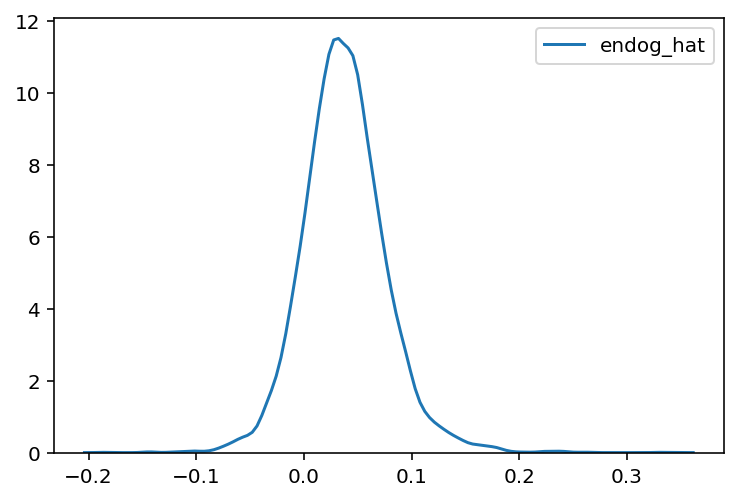

In [90]:
# density of coeff on endog_hat in bootstrapping
sns.kdeplot(result_test.beta_hat_boots['endog_hat'])

In [103]:
result_test.result2.params

const                 0.598030
endog_hat             0.054964
endog_sq_hat          0.000045
school_GP             0.076259
male                 -0.023395
age                   0.006679
urban                 0.028395
fam_small             0.026813
fam_split            -0.010078
mother               -0.019258
father               -0.004280
failures             -0.103960
school_sup           -0.111571
famsup               -0.030877
paid                 -0.039287
activities           -0.001779
nursery              -0.019895
higher                0.101456
internet              0.009379
romantic             -0.032929
absences              0.000699
Mjob_teach            0.030767
Mjob_health           0.119591
Mjob_civil            0.042555
Mjob_other            0.003629
Fjob_teach            0.079143
Fjob_health          -0.148210
Fjob_civil           -0.036439
Fjob_other            0.015313
Medu_primary         -0.055770
                        ...   
Fedu_primary         -0.067723
Fedu_5_9

In [100]:
import quadratic2SLS as q2sls
import importlib
importlib.reload(q2sls)

Y = student_perf.G3_perc
X = student_perf[['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'reason_home', 'reason_course', 'reason_reputation',
                  'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_perf['studytime_continuous']
student_perf['artificial_instrument'] = 1*(student_perf.reason == 'home')*1*(student_perf.traveltime > 1)
Z = student_perf[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model_test2 = q2sls. Quadratic2SLS(Y, X, X_endog, Z, X, Z)
result_test2 = model_test2.fit(cov_type='Bootstrap', n_iter = 100)
result_test2.beta_hat_boots.mean(axis=0)

100%|██████████| 100/100 [00:02<00:00, 44.86it/s]


const                 0.644066
endog_hat             0.045771
endog_sq_hat          0.000095
school_GP             0.076658
male                 -0.030517
age                   0.006755
urban                 0.031893
fam_small             0.027752
fam_split            -0.011478
mother               -0.019793
father               -0.000606
failures             -0.110175
school_sup           -0.110082
famsup               -0.023048
paid                 -0.030029
activities            0.002229
nursery              -0.020711
higher                0.106207
internet              0.005548
romantic             -0.031628
absences             -0.000425
Mjob_teach            0.035909
Mjob_health           0.110778
Mjob_civil            0.044494
Mjob_other            0.005242
Fjob_teach            0.074248
Fjob_health          -0.137192
Fjob_civil           -0.037732
Fjob_other            0.011543
Medu_primary         -0.049074
                        ...   
Fedu_primary         -0.079940
Fedu_5_9